#DATASCI W261: Machine Learning at Scale

**Nick Hamlin** (nickhamlin@gmail.com)  
**Tigi Thomas** (tgthomas@berkeley.edu)  
**Rock Baek** (rockb1017@gmail.com)  
**Hussein Danish** (husseindanish@gmail.com)  
  
Time of Submission: 9:23 PM EST, Wednesday, Feb 24, 2016  
W261-3, Spring 2016  
Week 6 Homework

###Submission Notes:
- For each problem, we've included a summary of the question as posed in the instructions.  In many cases, we have not included the full text to keep the final submission as uncluttered as possible.  For reference, we've included a link to the original instructions in the "Useful Reference" below.
- Problem statements are listed in *italics*, while our responses are shown in plain text. 
- We've included the full output of the mapreduce jobs in our responses so that counter results are shown.  However, these don't always render nicely into PDF form.  In these situations, please reference [the complete rendered notebook on Github](https://github.com/nickhamlin/mids_261_homework/blob/master/HW4/MIDS-W261-2015-HWK-Week06-Hamlin-Thomas-Baek-Danish.ipynb)

###Useful References:
- **[Original Assignment Instructions](https://www.dropbox.com/sh/5bex8l871t0bg3a/AABXfLW7xv9OUAzY01fMa29za/HW6-Questions.txt?dl=0)**
- **[Linear Regression in MRJob](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/kritdm3mo1daolj/MrJobLinearRegressionGD.ipynb)


In [5]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
#Render matplotlib charts in notebook
%matplotlib inline

#Import some modules we know we'll use frequently
import numpy as np
import pylab as plt

## HW 6.0

*In mathematics, computer science, economics, or management science what is mathematical optimization? Give an example of a optimization problem that you have worked with directly or that your organization has worked on. Please describe the objective function and the decision variables. Was the project successful (deployed in the real world)? Describe.*



##HW6.1 

### HW 6.1 Problem Statement
Optimization theory: 
For unconstrained univariate optimization what are the first order necessary Conditions for Optimality (FOC).  What are the second order optimality conditions (SOC)? Give a mathematical defintion. Also in python, plot the univartiate function 
X^3 -12x^2-6 defined over the real  domain -6 to +6. 

Also plot its corresponding first and second derivative functions. Eyeballing these graphs, identify candidate optimal points and then classify them as local minimums or maximums. Highlight and label these points in your graphs. Justify your responses using the FOC and SOC.

For unconstrained multi-variate optimization what are the first order  Necessary Conditions for Optimality (FOC).  What are the second order optimality conditions (SOC)? Give a mathematical defintion. What is the Hessian matrix in this context?

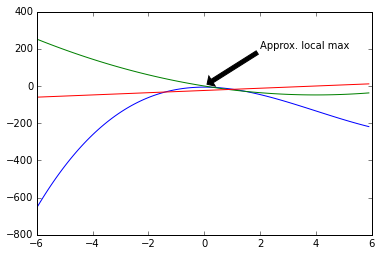

In [21]:
import numpy as np
import pylab as plt

def f(x):
    """The function in question"""
    return x**3-12*x**2-6

def dev1f(x):
    """The first derivative of our function"""
    return 3*x**2-24*x

def dev2f(x):
    """The second derivative of our function"""
    return 6*x-24

x=np.arange(-6,6,.1)
y0=f(x)
y1=dev1f(x)
y2=dev2f(x)

plt.plot(x,y0)
plt.plot(x,y1)
plt.plot(x,y2)

plt.annotate('Approx. local max', xy=(0, 0), xytext=(2, 200),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()


##HW6.2

### HW 6.2 Problem Statement
Taking x=1 as the first approximation(xt1) of a root of X^3 + 2x -4 = 0, use the Newton-Raphson method to calculate the second approximation (denoted as xt2) of this root. (Hint the solution is xt2=1.2)

In [4]:
from __future__ import division

def f(x):
    """Calculate the value of our function"""
    return x**3+2*x-4

def dev1f(x):
    """Calculate the value of our function's derivative"""
    return 3*x**2+2

def iterate_nr_method(xt1):
    """Calculate a single iteration of the Newton-Raphson method for our function"""
    xt2=xt1-(f(xt1)/dev1f(xt1))
    return xt2

iterate_nr_method(1)


1.2

##HW6.3 

### HW 6.3 Problem Statement
Convex optimization 
What makes an optimization problem convex? What are the first order  Necessary Conditions for Optimality in convex optimization.  What are the second order optimality conditions for convex optimization? Are both necessary to determine the maximum or minimum of candidate optimal solutions?

Fill in the BLANKS here:
Convex minimization, a subfield of optimization, studies the problem of minimizing BLANK functions over BLANK sets. The BLANK property can make optimization in some sense "easier" than the general case - for example, any local minimum must be a global minimum.

##HW 6.4
The learning objective function for weighted ordinary least squares (WOLS) (aka weight linear regression) is defined as follows:

0.5\* sumOverTrainingExample i (weight_i \* (W \* X_i - y_i)^2)

Where training set consists of input variables X ( in vector form) and a target variable y, and W is the vector of coefficients for the linear regression model.

Derive the gradient for this weighted OLS by hand; showing each step and also explaining each step.

##HW 6.5

### HW 6.5 Problem Statement
Write a MapReduce job in MRJob to do the training at scale of a weighted OLS model using gradient descent.

Generate one million datapoints just like in the following notebook:  http://nbviewer.ipython.org/urls/dl.dropbox.com/s/kritdm3mo1daolj/MrJobLinearRegressionGD.ipynb

Weight each example as follows: 

weight(x)= abs(1/x)

Sample 1% of the data in MapReduce and use the sampled dataset to train a (weighted if available in SciKit-Learn) [linear regression model locally using  SciKit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Plot the resulting weighted linear regression model versus the original model that you used to generate the data. Comment on your findings.

#TODO: This is the (slightly edited, so it actually runs) code from Jimi's notebook.  Need to modify to accept the weight listed above

In [77]:
size = 10000
x = np.random.uniform(-4, 4, size)
y = x * 1.0 - 4 + np.random.normal(0,0.5,size)
data = zip(y,x) #NOTICE THAT THE Y-VALUE COMES FIRST!
np.savetxt('LinearRegression.csv',data,delimiter = ",")

In [78]:
%%writefile MrJobBatchGDUpdate_LinearRegression.py
from mrjob.step import MRStep
from mrjob.job import MRJob

# This MrJob calculates the gradient of the entire training set 
#     Mapper: calculate partial gradient for each example  
#     
class MrJobBatchGDUpdate_LinearRegression(MRJob):
    # run before the mapper processes any input
    def read_weightsfile(self):
        # Read weights file
        with open('weights.txt', 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialze gradient for this iteration
        self.partial_Gradient = [0]*len(self.weights)
        self.partial_count = 0
    
    # Calculate partial gradient for each example 
    def partial_gradient(self, _, line):
        D = (map(float,line.split(',')))
        # y_hat is the predicted value given current weights
        y_hat = self.weights[0]+self.weights[1]*D[1]
        # Update parial gradient vector with gradient form current example
        self.partial_Gradient =  [self.partial_Gradient[0]+ D[0]-y_hat, self.partial_Gradient[1]+(D[0]-y_hat)*D[1]]
        self.partial_count = self.partial_count + 1
        #yield None, (D[0]-y_hat,(D[0]-y_hat)*D[1],1)
    
    # Finally emit in-memory partial gradient and partial count
    def partial_gradient_emit(self):
        yield None, (self.partial_Gradient,self.partial_count)
        
    # Accumulate partial gradient from mapper and emit total gradient 
    # Output: key = None, Value = gradient vector
    def gradient_accumulater(self, _, partial_Gradient_Record): 
        total_gradient = [0]*2
        total_count = 0
        for partial_Gradient,partial_count in partial_Gradient_Record:
            total_count = total_count + partial_count
            total_gradient[0] = total_gradient[0] + partial_Gradient[0]
            total_gradient[1] = total_gradient[1] + partial_Gradient[1]
        yield None, [v/total_count for v in total_gradient]
    
    def steps(self):
        return [MRStep(mapper_init=self.read_weightsfile,
                       mapper=self.partial_gradient,
                       mapper_final=self.partial_gradient_emit,
                       reducer=self.gradient_accumulater)] 
    
if __name__ == '__main__':
    MrJobBatchGDUpdate_LinearRegression.run()

Overwriting MrJobBatchGDUpdate_LinearRegression.py


In [79]:
from numpy import random,array
from MrJobBatchGDUpdate_LinearRegression import MrJobBatchGDUpdate_LinearRegression

learning_rate = 0.05
stop_criteria = 0.000005

# Generate random values as inital weights
weights = array([random.uniform(-3,3),random.uniform(-3,3)])
# Write the weights to the files
with open('weights.txt', 'w+') as f:
    f.writelines(','.join(str(j) for j in weights))

# create a mrjob instance for batch gradient descent update over all data
mr_job = MrJobBatchGDUpdate_LinearRegression(args=['LinearRegression.csv','--file',
                                                   'weights.txt','--no-strict-protocols'])
# Update centroids iteratively
i = 0
while(1):
    print "iteration ="+str(i)+"  weights =",weights
    # Save weights from previous iteration
    weights_old = weights
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            # value is the gradient value
            key,value =  mr_job.parse_output_line(line)
            # Update weights
            weights = weights + learning_rate*array(value)
    i = i + 1
    # Write the updated weights to file 
    with open('weights.txt', 'w+') as f:
        f.writelines(','.join(str(j) for j in weights))
    # Stop if weights get converged
    if(sum((weights_old-weights)**2)<stop_criteria):
        break
        
print "Final weights\n"
print weights

iteration =0  weights = [ 2.53361522  0.33900531]
iteration =1  weights = [ 2.20725614  0.514381  ]
iteration =2  weights = [ 1.89718811  0.64308105]
iteration =3  weights = [ 1.60260376  0.73753885]
iteration =4  weights = [ 1.32273414  0.80687525]
iteration =5  weights = [ 1.05684737  0.85778113]
iteration =6  weights = [ 0.80424713  0.89516483]
iteration =7  weights = [ 0.56427117  0.92262705]
iteration =8  weights = [ 0.3362898   0.94280926]
iteration =9  weights = [ 0.11970441  0.95764924]
iteration =10  weights = [-0.086054    0.96856858]
iteration =11  weights = [-0.28152615  0.97661021]
iteration =12  weights = [-0.46722593  0.98253927]
iteration =13  weights = [-0.64364164  0.98691711]
iteration =14  weights = [-0.81123722  0.9901556 ]
iteration =15  weights = [-0.97045353  0.99255696]
iteration =16  weights = [-1.12170939  0.99434292]
iteration =17  weights = [-1.26540272  0.99567624]
iteration =18  weights = [-1.4019116   0.99667636]
iteration =19  weights = [-1.53159519  0.

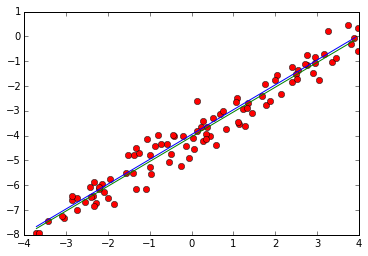

In [98]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import random as rand #avoid namespace collisions

#Randomly sample 1% of our data
n = 10000 #number of records in file
s = int(n*0.01) #desired sample size
filename = "LinearRegression.csv"
skip = sorted(rand.sample(xrange(n),n-s))
df = pd.read_csv(filename, skiprows=skip, header=None)

#Set up background stuff to plot mapreduce data
floor_x=min(df[1])
ceiling_x=max(df[1])
step_x=(ceiling_x-floor_x)/s
pred_x=np.arange(floor_x,ceiling_x,step_x)

def get_line(x,m,b):
    return m*x+b

mr_intercept=weights[0]
mr_slope=weights[1]
pred_y_mr=get_line(pred_x,mr_slope,mr_intercept)

#Build Sklearn model
sklearn_model=LinearRegression()
sklearn_model.fit(df[1].reshape(-1,1),df[0])
sk_slope=sklearn_model.coef_
sk_intercept=sklearn_model.intercept_

pred_y_sk=get_line(pred_x,sk_slope,sk_intercept)

#Actually make the plots
plt.plot(df[1],df[0],'ro') #Plot data points
plt.plot(pred_x,pred_y_mr) #Plot Mapreduce line
plt.plot(pred_x,pred_y_sk) #Plot Sklearn line
plt.show()


##HW6.6
Clean up notebook for GMM via EM

Using the following notebook as a starting point:

http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/0t7985e40fovlkw/EM-GMM-MapReduce%20Design%201.ipynb 

Improve this notebook as follows:
-- Add in equations into the notebook (not images of equations) 
-- Number the equations
-- Make sure the equation notation matches the code and the code and comments refer to the equations numbers
-- Comment the code
-- Rename/Reorganize the code to make it more readable
-- Rerun the examples similar graphics (or possibly better graphics)

##HW6.7 
Implement Bernoulli Mixture Model via EM
Implement the EM clustering algorithm to determine Bernoulli Mixture Model for discrete data in MRJob.

As a unit test:


As a test: use the same dataset from HW 4.5, the Tweet Dataset. 
Using this data, you will implement a 1000-dimensional EM-based Bernoulli Mixture Model  algorithm in MrJob on the users
by their 1000-dimensional word stripes/vectors using K = 4.  Repeat this experiment using your KMeans MRJob implementation fron HW4.
Report the rand index score using the class code as ground truth label for both algorithms and comment on your findings.

Here is some more information on the Tweet Dataset.

Here you will use a different dataset consisting of word-frequency distributions 
for 1,000 Twitter users. These Twitter users use language in very different ways,
and were classified by hand according to the criteria:

0: Human, where only basic human-human communication is observed.

1: Cyborg, where language is primarily borrowed from other sources
(e.g., jobs listings, classifieds postings, advertisements, etc...).

2: Robot, where language is formulaically derived from unrelated sources
(e.g., weather/seismology, police/fire event logs, etc...).

3: Spammer, where language is replicated to high multiplicity
(e.g., celebrity obsessions, personal promotion, etc... )

Check out the preprints of  recent research,
which spawned this dataset:

http://arxiv.org/abs/1505.04342
http://arxiv.org/abs/1508.01843

The main data lie in the accompanying file:

topUsers_Apr-Jul_2014_1000-words.txt

and are of the form:

USERID,CODE,TOTAL,WORD1_COUNT,WORD2_COUNT,...
.
.

where

USERID = unique user identifier
CODE = 0/1/2/3 class code
TOTAL = sum of the word counts

Using this data, you will implement a 1000-dimensional K-means algorithm in MrJob on the users
by their 1000-dimensional word stripes/vectors using several 
centroid initializations and values of K.